# 高收益信贷利率

In [17]:
import datetime as dt

import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

下载高收益债券收益率，ICE BofA US High Yield Index Effective Yield

In [2]:
# series_id = "BAMLH0A0HYM2EY"
# start_date = "2000-01-01"
# end_date = "2024-04-01"

# data = pdr.get_data_fred(series_id, start=start_date, end=end_date)

In [3]:
# data.to_csv("../data/high_yield_bond_rates.csv", index=True)

读取BTC历史价格，合并数据，然后绘制图表

In [18]:
btc_prices = pd.read_csv("../data/bitstamp_btcusd_1d.csv", index_col=0, parse_dates=True,
                         usecols=["timestamp", "close"])
btc_prices.index.name = "date"
btc_prices

,close
date,
2012-01-01,5.00
2012-01-02,5.00
2012-01-03,5.29
2012-01-04,5.57
2012-01-05,6.65
...,...
2024-02-26,54524.00
2024-02-27,57068.00
2024-02-28,62512.00


In [25]:
high_yield_bond_rates = pd.read_csv("../data/high_yield_bond_rates.csv", index_col=0, parse_dates=True)
high_yield_bond_rates.index.name = "date"
high_yield_bond_rates.rename(columns={"BAMLH0A0HYM2EY": "bond_rate"}, inplace=True)
high_yield_bond_rates

,bond_rate
date,
2000-01-03,11.39
2000-01-04,11.43
2000-01-05,11.47
2000-01-06,11.47
2000-01-07,11.47
...,...
2024-03-11,7.50
2024-03-12,7.50
2024-03-13,7.48


BTC一周交易7天，债券利率周末没有数据，合并数据时以BTC索引为准，缺失的利率数据用前值填充。

In [40]:
data = pd.merge(btc_prices, high_yield_bond_rates,
                how="outer", left_index=True, right_index=True)
data = data.asfreq("D")  # fill in missing dates
data.ffill(inplace=True)  # fill in missing bond rates

window = 365*4
data["bond_rate_rolling_percent_rank"] = data["bond_rate"].rolling(window).rank(pct=True)
data.dropna(inplace=True)

data = data.loc["2012-01-01":"2024-02-29"]
data.head(20)

,close,bond_rate,bond_rate_rolling_percent_rank
date,,,
2012-01-01,5.00,8.29,0.256849
2012-01-02,5.00,8.29,0.257192
2012-01-03,5.29,8.17,0.240753
2012-01-04,5.57,8.13,0.235274
2012-01-05,6.65,8.12,0.232877
2012-01-06,6.00,8.09,0.227740
2012-01-07,6.80,8.09,0.228082
2012-01-08,7.00,8.09,0.228425
2012-01-09,6.30,8.07,0.227055


In [41]:
data["bond_rate_percent_rank"] = data["bond_rate"].rank(pct=True)
data

,close,bond_rate,bond_rate_rolling_percent_rank,bond_rate_percent_rank
date,,,,
2012-01-01,5.00,8.29,0.256849,0.878348
2012-01-02,5.00,8.29,0.257192,0.878348
2012-01-03,5.29,8.17,0.240753,0.863043
2012-01-04,5.57,8.13,0.235274,0.855165
2012-01-05,6.65,8.12,0.232877,0.853702
...,...,...,...,...
2024-02-25,51722.00,7.61,0.566438,0.793270
2024-02-26,54524.00,7.63,0.569521,0.796759
2024-02-27,57068.00,7.67,0.574658,0.801485


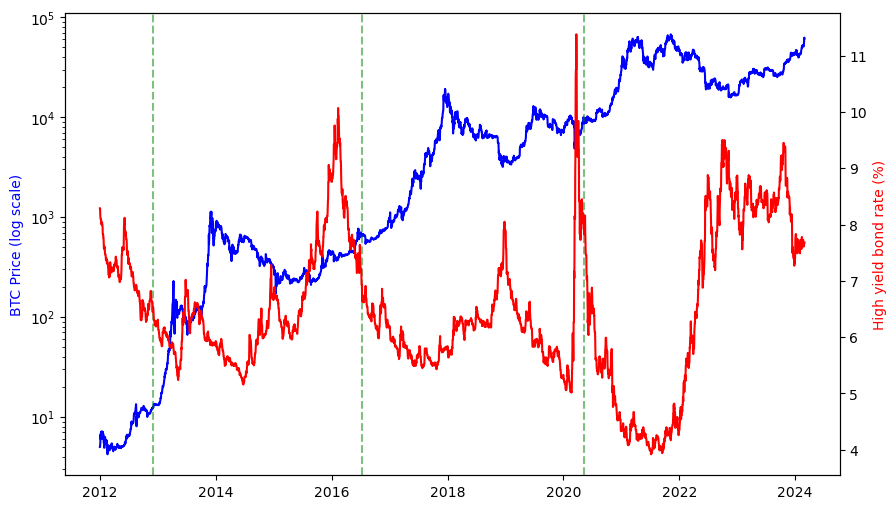

In [42]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# BTC 历史收盘价，用对数刻度
ax1.plot(data.index, data["close"], label="BTC Price", color="b")
ax1.set_yscale("log")
ax1.set_ylabel("BTC Price (log scale)", color="b")

# 创建新的y轴，共享x轴
ax2 = ax1.twinx()

# 高收益债券利率
ax2.plot(data.index, data["bond_rate"], label="High yield bond rate", color="r")
ax2.set_ylabel("High yield bond rate (%)", color="r")

# 添加虚线表示BTC减半事件
halving_dates = ["2012-11-28", "2016-07-09", "2020-05-11"]
for date in halving_dates:
    date = dt.datetime.strptime(date, "%Y-%m-%d")
    ax1.axvline(x=date, color="g", linestyle="--", alpha=0.5)

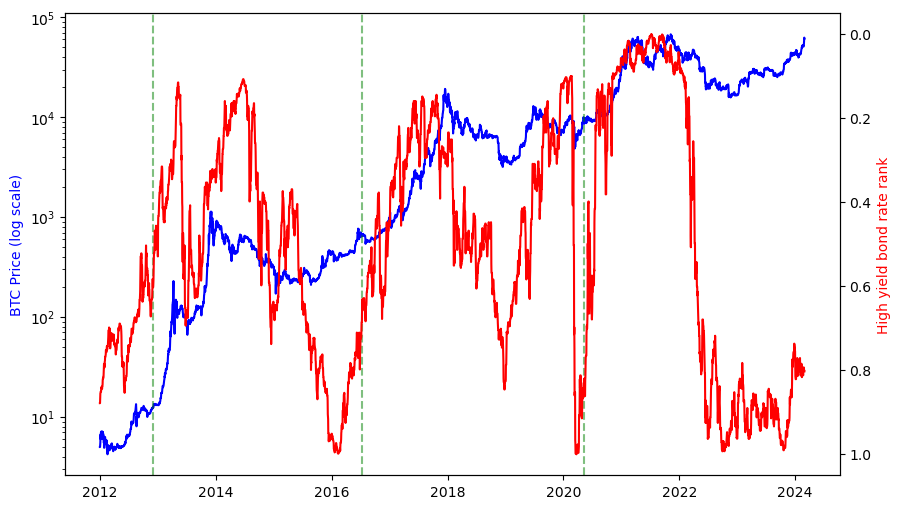

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# BTC 历史收盘价，用对数刻度
ax1.plot(data.index, data["close"], label="BTC Price", color="b")
ax1.set_yscale("log")
ax1.set_ylabel("BTC Price (log scale)", color="b")

# 创建新的y轴，共享x轴
ax2 = ax1.twinx()

# 高收益债券利率的百分位排名
ax2.plot(data.index, data["bond_rate_percent_rank"], label="High yield bond rate(rank)", color="r")
ax2.set_ylabel("High yield bond rate rank", color="r")
ax2.invert_yaxis()  # 百分位排名越高，利率越低

# 添加虚线表示BTC减半事件
halving_dates = ["2012-11-28", "2016-07-09", "2020-05-11"]
for date in halving_dates:
    date = dt.datetime.strptime(date, "%Y-%m-%d")
    ax1.axvline(x=date, color="g", linestyle="--", alpha=0.5)